**TASK:** *Detection of line segments and circular arcs*

**SUBMITTED BY**

**NAME** *Kipchirchir Raphael*

**NEPTUN CODE:** *LGL7CS*

**DATE** *2025/11/15*

In [1]:
import numpy as np
from scipy.optimize import least_squares
import os
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob

# ==========================================================
# 1. Load polar coordinates from text file
# ==========================================================
def load_polar(filename):
    """
    Loads polar coordinate data from a given file.

    Expected file format:
        angle(deg)   radius(mm)
    - Lines starting with '#' are ignored.
    - Lines with fewer than two values are skipped.
    - Returns two numpy arrays: angles, radii.
    """
    angles, radii = [], []
    try:
        with open(filename, 'r') as f:
            for line in f:
                line = line.strip()
                if not line or line.startswith('#'):
                    continue
                parts = line.split()
                if len(parts) >= 2:
                    try:
                        angle = float(parts[0])
                        radius = float(parts[1])
                        angles.append(angle)
                        radii.append(radius)
                    except ValueError:
                        # Skip malformed numeric lines
                        continue
        print(f"Loaded {len(angles)} points from {filename}")
    except Exception as e:
        print(f"Error reading {filename}: {e}")

    return np.array(angles), np.array(radii)

# ==========================================================
# 2. Convert polar to Cartesian (meters)
# ==========================================================
def polar_to_cartesian(angles, radii):
    """
    Converts polar coordinates (angle in degrees, radius in mm)
    to Cartesian coordinates in meters.

    Returns Nx2 array: [[x1, y1], [x2, y2], ...]
    """
    angles_rad = np.deg2rad(angles)
    x = (radii / 1000.0) * np.cos(angles_rad)
    y = (radii / 1000.0) * np.sin(angles_rad)
    return np.vstack((x, y)).T

# ==========================================================
# 3. Line distance helpers
# ==========================================================
def distance_to_line(points, a, b, c):
    """
    Computes perpendicular distance of points to the line ax + by + c = 0.
    Returns array of distances.
    """
    denom = np.sqrt(a*a + b*b)
    if denom == 0:
        return np.full((len(points),), np.inf)
    return np.abs(a * points[:, 0] + b * points[:, 1] + c) / denom


def fit_line_two_points(p1, p2):
    """
    Computes a line model passing through two points.

    Returns normalized coefficients (a, b, c) for ax + by + c = 0
    such that sqrt(a^2 + b^2) = 1.
    """
    dx, dy = p2 - p1
    norm = np.hypot(dx, dy)
    if norm == 0:
        return None

    # Line normal is perpendicular to direction (dx, dy)
    a = dy / norm
    b = -dx / norm
    c = -(a * p1[0] + b * p1[1])
    return a, b, c

# ==========================================================
# 4. Optimal line fitting using SVD
# ==========================================================
def fit_line_optimal(points):
    """
    Fits a line optimally (total least squares) using SVD.

    Steps:
    - Center points around centroid
    - Compute SVD
    - Normal vector = the singular vector associated with smallest singular value

    Returns (a, b, c) normalized.
    """
    if len(points) < 2:
        return None

    mean = np.mean(points, axis=0)
    centered = points - mean

    try:
        _, _, vt = np.linalg.svd(centered, full_matrices=False)
        normal = vt[-1]    # Least variance direction
        a, b = float(normal[0]), float(normal[1])
    except np.linalg.LinAlgError:
        # Fallback using eigen decomposition
        C = centered.T @ centered
        vals, vecs = np.linalg.eigh(C)
        normal = vecs[:, np.argmin(vals)]
        a, b = normal[0], normal[1]

    # Normalize
    n = np.hypot(a, b)
    if n == 0:
        return None
    a, b = a / n, b / n
    c = - (a * mean[0] + b * mean[1])

    return a, b, c

# ==========================================================
# 5. Line length computation
# ==========================================================
def get_line_length(points, a, b):
    """
    Computes total projected span of `points` onto the line direction.

    Direction vector is perpendicular to line normal: (-b, a).
    """
    direction = np.array([-b, a])
    projections = np.dot(points, direction)
    return projections.max() - projections.min()

# ==========================================================
# 6. Circle model helpers
# ==========================================================
def distance_to_circle(points, h, k, r):
    """
    Returns absolute difference between each point's distance to center
    and the circle radius.
    """
    return np.abs(np.hypot(points[:, 0] - h, points[:, 1] - k) - r)


def fit_circle_least_squares(points):
    """
    Fits a circle using nonlinear least squares.

    Returns (h, k, r) or None.
    """
    if len(points) < 3:
        return None

    def residuals(c):
        Ri = np.hypot(points[:, 0] - c[0], points[:, 1] - c[1])
        return Ri - Ri.mean()

    center_est = points.mean(axis=0)
    try:
        res = least_squares(residuals, center_est)
        h, k = res.x
        r = np.mean(np.hypot(points[:, 0] - h, points[:, 1] - k))
        return h, k, float(r)
    except Exception:
        return None

# ==========================================================
# 7. Collinearity test for circle sampling
# ==========================================================
def are_collinear(p1, p2, p3, tol=1e-6):
    """
    True if triangle area formed by p1,p2,p3 is nearly zero.
    """
    area = np.abs((p1[0]*(p2[1]-p3[1]) +
                   p2[0]*(p3[1]-p1[1]) +
                   p3[0]*(p1[1]-p2[1])) / 2.0)
    return area < tol

# ==========================================================
# 8. Sequential RANSAC (line + circle)
# ==========================================================
def sequential_ransac(points,
                      line_thresh=0.02,
                      circle_thresh=0.02,
                      line_min_pts=10,
                      line_min_len=0.4,
                      circle_min_pts=8,
                      circle_rmin=0.2,
                      circle_rmax=0.5,
                      num_iterations=2000):
    """
    Attempts to extract line and circle models using sequential RANSAC.

    For each iteration:
    - Run RANSAC for line: random 2‑point samples
    - Run RANSAC for circle: random 3‑point samples
    - Refit the best inlier sets using optimal methods
    - Remove inliers from dataset

    Returns list of tuples: (model_type, params, inlier_indices)
    """

    remaining_indices = list(range(len(points)))
    models = []

    while len(remaining_indices) >= 3:
        best_line_inliers, best_line_model = [], None
        best_circle_inliers, best_circle_model = [], None

        # ----- LINE RANSAC -----
        for _ in tqdm(range(num_iterations), desc="Line RANSAC", ncols=80):
            if len(remaining_indices) < 2:
                break
            sample_idx = np.random.choice(remaining_indices, 2, replace=False)
            p1, p2 = points[sample_idx]
            model = fit_line_two_points(p1, p2)
            if model is None:
                continue
            a, b, c = model
            dists = distance_to_line(points[remaining_indices], a, b, c)

            inliers = [remaining_indices[i] for i, d in enumerate(dists) if d < line_thresh]

            if len(inliers) > len(best_line_inliers):
                best_line_inliers = inliers
                best_line_model = model

        # Refit line optimally
        if len(best_line_inliers) >= line_min_pts:
            pts = points[best_line_inliers]
            refit = fit_line_optimal(pts)
            if refit is not None:
                a, b, c = refit
                length = get_line_length(pts, a, b)
                if length >= line_min_len:
                    models.append(('line', refit, best_line_inliers))

        # ----- CIRCLE RANSAC -----
        for _ in tqdm(range(num_iterations), desc="Circle RANSAC", ncols=80):
            if len(remaining_indices) < 3:
                break
            sample_idx = np.random.choice(remaining_indices, 3, replace=False)
            sample_pts = points[sample_idx]
            if are_collinear(*sample_pts):
                continue
            model = fit_circle_least_squares(sample_pts)
            if model is None:
                continue
            h, k, r = model
            dists = distance_to_circle(points[remaining_indices], h, k, r)

            inliers = [remaining_indices[i] for i, d in enumerate(dists) if d < circle_thresh]
            if len(inliers) > len(best_circle_inliers):
                best_circle_inliers = inliers
                best_circle_model = model

        # Refit circle
        if len(best_circle_inliers) >= circle_min_pts:
            pts = points[best_circle_inliers]
            refit = fit_circle_least_squares(pts)
            if refit is not None:
                h, k, r = refit
                if circle_rmin <= r <= circle_rmax:
                    models.append(('circle', refit, best_circle_inliers))

        if not best_line_inliers and not best_circle_inliers:
            break

        # Remove inliers of detected models
        removed = set(best_line_inliers + best_circle_inliers)
        remaining_indices = [i for i in remaining_indices if i not in removed]

    return models

# ==========================================================
# 9. Save PLY visualization
# ==========================================================
def save_ply(filename, points, models):
    """
    Saves point cloud with color‑coding:
        - line inliers: blue
        - circle inliers: red
        - others: white
    """
    colors = np.full((len(points), 3), [255, 255, 255], dtype=int)

    for m_type, _, inliers in models:
        if m_type == 'line':
            colors[inliers] = [0, 0, 255]
        else:
            colors[inliers] = [255, 0, 0]

    with open(filename, 'w') as f:
        f.write("ply\nformat ascii 1.0\n")
        f.write(f"element vertex {len(points)}\n")
        f.write("property float x\nproperty float y\nproperty float z\n")
        f.write("property uchar red\nproperty uchar green\nproperty uchar blue\n")
        f.write("end_header\n")

        for i in range(len(points)):
            f.write(f"{points[i,0]:.6f} {points[i,1]:.6f} 0.0 "
                    f"{colors[i,0]} {colors[i,1]} {colors[i,2]}\n")

    print(f"Saved PLY file: {filename}")

# ==========================================================
# 10. Plot detected models
# ==========================================================
def plot_models(points, models, show=True):
    """
    Visualizes:
      - raw points (light grey)
      - line inliers (blue)
      - circle inliers (red)
      - fitted shapes (dashed)
    """
    plt.figure(figsize=(8, 8))
    plt.scatter(points[:,0], points[:,1], c='lightgrey', s=5)

    for m_type, model, inliers in models:
        pts = points[inliers]

        if m_type == 'line':
            a, b, c = model
            plt.scatter(pts[:,0], pts[:,1], c='blue', s=10)

            # Compute segment for visualization
            direction = np.array([-b, a])
            proj = np.dot(pts, direction)
            tmin, tmax = proj.min(), proj.max()
            centroid = pts.mean(axis=0)
            ts = np.linspace(tmin - 0.1, tmax + 0.1, 50)
            seg = centroid + np.outer(ts, direction)
            plt.plot(seg[:,0], seg[:,1], 'b--', linewidth=1)

        else:  # circle
            h, k, r = model
            plt.scatter(pts[:,0], pts[:,1], c='red', s=10)
            theta = np.linspace(0, 2*np.pi, 200)
            xc = h + r * np.cos(theta)
            yc = k + r * np.sin(theta)
            plt.plot(xc, yc, 'r--', linewidth=1)

    plt.axis('equal')
    plt.xlabel('X [m]')
    plt.ylabel('Y [m]')
    plt.title('Detected geometric models')

    if show:
        plt.show()

# ==========================================================
# 11. Batch processing workflow
# ==========================================================
def process_files(file_list, visualize=False):
    """
    Processes a list of polar data files:
      1. Load data
      2. Convert to Cartesian
      3. Run sequential RANSAC
      4. Save PLY visualization
      5. Append textual summary to results_summary.txt
    """

    summary_path = os.path.join(os.getcwd(), "results_summary.txt")

    # Add run header
    with open(summary_path, "a") as report:
        report.write("\n\n" + "="*70 + "\n")
        report.write(f"New RANSAC Run - {datetime.now()}\n")
        report.write("="*70 + "\n")

    total_lines = total_circles = total_points = total_files = 0

    for fname in file_list:
        if not os.path.exists(fname):
            print(f"File not found: {fname}")
            continue

        total_files += 1
        angles, radii = load_polar(fname)
        if len(angles) == 0:
            print(f"Skipping {fname}: no valid data.")
            continue

        points = polar_to_cartesian(angles, radii)
        total_points += len(points)

        models = sequential_ransac(points)

        # Count model types
        n_lines = sum(1 for m in models if m[0] == 'line')
        n_circles = sum(1 for m in models if m[0] == 'circle')
        total_lines += n_lines
        total_circles += n_circles

        # Build summary block
        summary = []
        summary.append("\n" + "="*60)
        summary.append(f"File: {fname}")
        summary.append(f"Total points: {len(points)}")
        summary.append(f"Detected: {len(models)} models ({n_lines} lines, {n_circles} circles)")
        summary.append("-"*60)

        if models:
            header = f"{'No.':<5}{'Type':<10}{'Inliers':<10}{'Details':<45}"
            summary.append(header)
            summary.append("-"*60)

            for idx, (m_type, model, inliers) in enumerate(models, 1):
                if m_type == 'line':
                    a, b, c = model
                    length = get_line_length(points[inliers], a, b)
                    details = f"Eq: {a:.4f}x + {b:.4f}y + {c:.4f}=0 | Len={length:.3f}m"
                else:
                    h, k, r = model
                    details = f"Center=({h:.4f}, {k:.4f}) | R={r:.4f}m"

                summary.append(f"{idx:<5}{m_type.title():<10}{len(inliers):<10}{details:<45}")
        else:
            summary.append("No models detected.")

        summary.append("="*60 + "\n")
        block = "\n".join(summary)

        print(block)
        with open(summary_path, "a") as report:
            report.write(block + "\n")

        # Save visualization PLY
        out_ply = f"{os.path.splitext(fname)[0]}.ply"
        save_ply(out_ply, points, models)

        if visualize:
            plot_models(points, models, show=True)

    # Final run summary
    final = []
    final.append("\n" + "-"*70)
    final.append("Run Totals")
    final.append("-"*70)
    final.append(f"Files processed: {total_files}")
    final.append(f"Total points: {total_points}")
    final.append(f"Total lines detected: {total_lines}")
    final.append(f"Total circles detected: {total_circles}")
    final.append("="*70 + "\n")

    footer = "\n".join(final)

    print(footer)
    with open(summary_path, "a") as report:
        report.write(footer + "\n")

    print(f"Summary saved to: {summary_path}")

Processing: ['1', '11', '21']
Loaded 764 points from 1


Circle RANSAC: 100%|███████████████████████| 2000/2000 [00:06<00:00, 295.22it/s]



File: 1
Total points: 764
Detected: 8 models (7 lines, 1 circles)
------------------------------------------------------------
No.  Type      Inliers   Details                                      
------------------------------------------------------------
1    Line      198       Eq: -0.4195x + 0.9078y + -0.1281=0 | Len=2.837m
2    Line      125       Eq: 0.0771x + 0.9970y + 1.6653=0 | Len=2.828m
3    Line      79        Eq: -0.2926x + 0.9562y + 0.4646=0 | Len=3.093m
4    Circle    97        Center=(0.0961, -0.0609) | R=0.4649m         
5    Line      44        Eq: 0.2145x + 0.9767y + -0.1882=0 | Len=0.663m
6    Line      30        Eq: -0.9978x + -0.0662y + -2.0580=0 | Len=1.045m
7    Line      18        Eq: 0.1743x + 0.9847y + 1.0695=0 | Len=3.170m
8    Line      13        Eq: 0.2302x + 0.9731y + 1.3447=0 | Len=3.122m

Saved PLY file: 1.ply


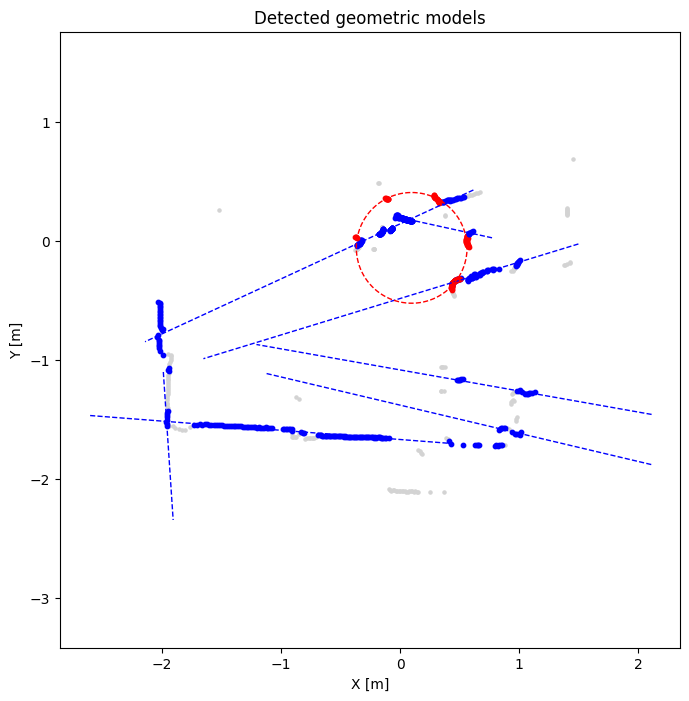

Loaded 788 points from 11


Circle RANSAC: 100%|███████████████████████| 2000/2000 [00:07<00:00, 272.61it/s]



File: 11
Total points: 788
Detected: 5 models (5 lines, 0 circles)
------------------------------------------------------------
No.  Type      Inliers   Details                                      
------------------------------------------------------------
1    Line      306       Eq: 0.5609x + -0.8279y + 1.2087=0 | Len=15.230m
2    Line      268       Eq: -0.5609x + 0.8279y + 1.5289=0 | Len=4.410m
3    Line      54        Eq: 0.8334x + 0.5526y + 2.5298=0 | Len=0.929m
4    Line      24        Eq: 0.8366x + 0.5478y + 2.0255=0 | Len=0.487m
5    Line      14        Eq: -0.6196x + 0.7849y + -2.1488=0 | Len=19.753m

Saved PLY file: 11.ply


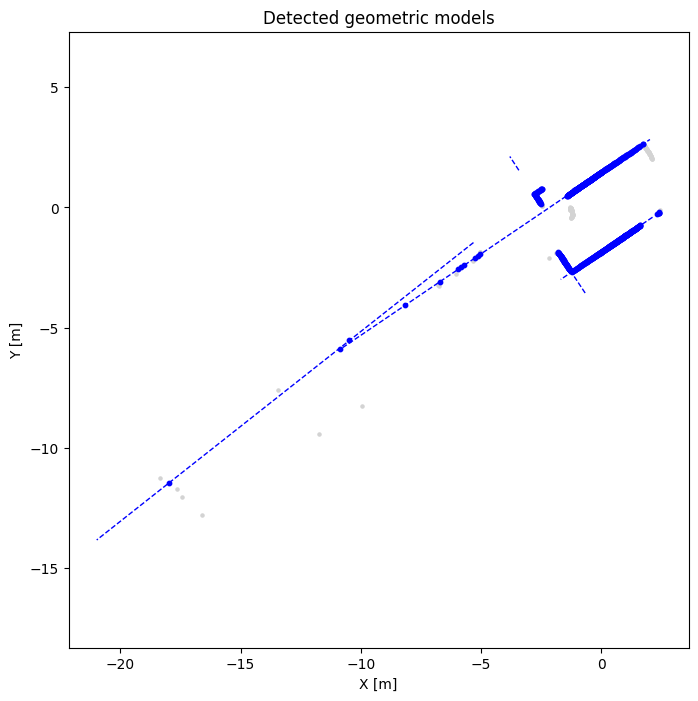

Loaded 856 points from 21


Circle RANSAC: 100%|███████████████████████| 2000/2000 [00:04<00:00, 493.53it/s]



File: 21
Total points: 856
Detected: 8 models (7 lines, 1 circles)
------------------------------------------------------------
No.  Type      Inliers   Details                                      
------------------------------------------------------------
1    Line      263       Eq: -0.9982x + -0.0600y + -3.3672=0 | Len=8.141m
2    Line      106       Eq: 0.6323x + -0.7747y + -5.1641=0 | Len=5.435m
3    Circle    129       Center=(0.7766, -0.0150) | R=0.2986m         
4    Line      47        Eq: 0.9909x + 0.1348y + 3.1419=0 | Len=27.715m
5    Line      29        Eq: 0.6130x + -0.7901y + -5.1711=0 | Len=7.907m
6    Line      28        Eq: -0.7892x + -0.6142y + 6.5422=0 | Len=6.530m
7    Line      16        Eq: 0.5025x + -0.8646y + -5.9152=0 | Len=2.007m
8    Line      13        Eq: 0.9674x + 0.2533y + 4.1974=0 | Len=3.514m

Saved PLY file: 21.ply


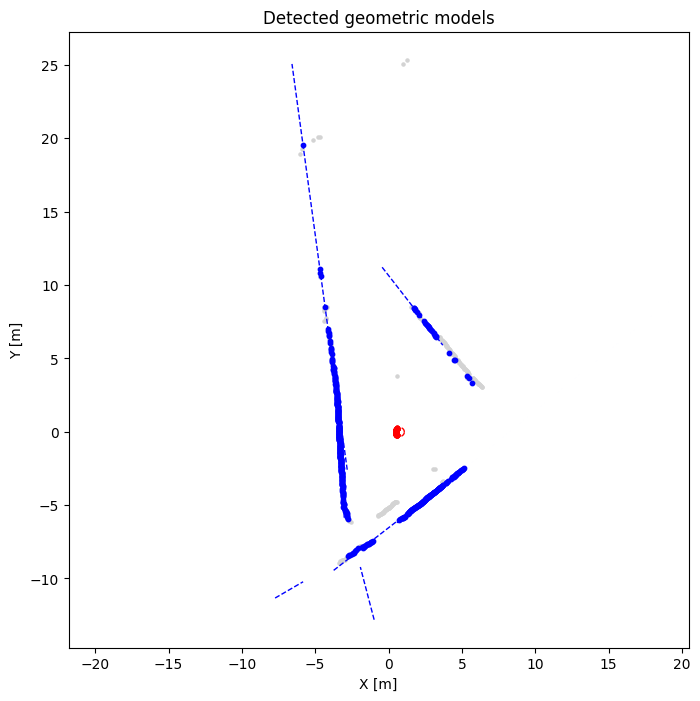


----------------------------------------------------------------------
Run Totals
----------------------------------------------------------------------
Files processed: 3
Total points: 2408
Total lines detected: 19
Total circles detected: 2

Summary saved to: /content/results_summary.txt


In [2]:
# ==========================================================
# 12. Main entry point (For my birth date files)
# ==========================================================
if __name__ == "__main__":
    files_to_process = ["1", "11", "21"]
    print("Processing:", files_to_process)
    process_files(files_to_process, visualize=True)

Processing: ['19', '29']
Loaded 888 points from 19


Circle RANSAC: 100%|███████████████████████| 2000/2000 [00:05<00:00, 356.16it/s]



File: 19
Total points: 888
Detected: 8 models (8 lines, 0 circles)
------------------------------------------------------------
No.  Type      Inliers   Details                                      
------------------------------------------------------------
1    Line      231       Eq: -0.9553x + -0.2957y + 1.7958=0 | Len=4.955m
2    Line      203       Eq: 0.9564x + 0.2920y + 1.3357=0 | Len=11.835m
3    Line      100       Eq: 0.9655x + 0.2605y + 1.4345=0 | Len=11.873m
4    Line      77        Eq: 0.2902x + -0.9570y + -1.0311=0 | Len=3.043m
5    Line      46        Eq: 0.2912x + -0.9566y + -1.1471=0 | Len=1.914m
6    Line      26        Eq: 0.9519x + 0.3064y + 0.7668=0 | Len=6.224m
7    Line      20        Eq: -0.2845x + 0.9587y + -3.9553=0 | Len=2.258m
8    Line      11        Eq: 0.2393x + -0.9709y + -7.8957=0 | Len=4.844m

Saved PLY file: 19.ply


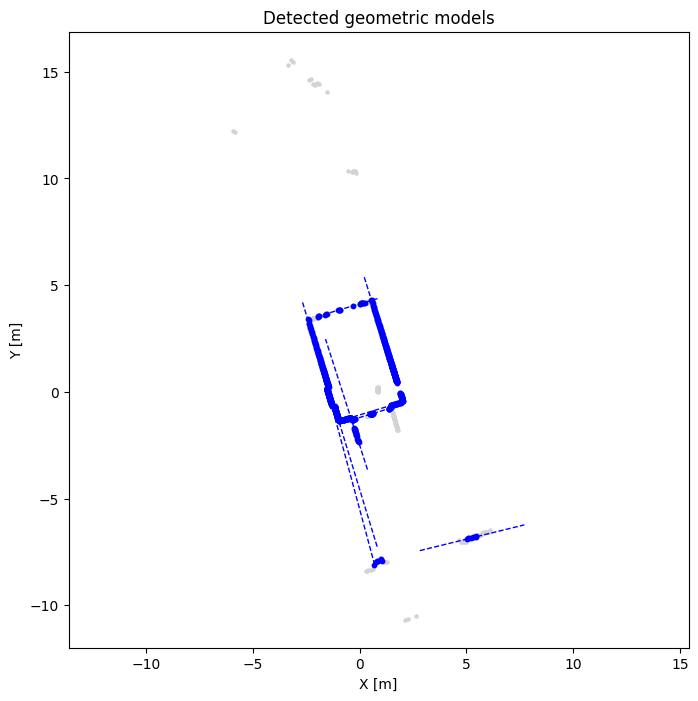

Loaded 572 points from 29


Circle RANSAC: 100%|███████████████████████| 2000/2000 [00:04<00:00, 412.40it/s]



File: 29
Total points: 572
Detected: 5 models (4 lines, 1 circles)
------------------------------------------------------------
No.  Type      Inliers   Details                                      
------------------------------------------------------------
1    Line      245       Eq: -0.9167x + -0.3997y + -3.9271=0 | Len=13.315m
2    Line      36        Eq: 0.9122x + 0.4096y + 3.9249=0 | Len=30.608m
3    Circle    38        Center=(2.0216, -1.6360) | R=0.3138m         
4    Line      15        Eq: 0.9164x + 0.4004y + 3.8924=0 | Len=10.911m
5    Line      10        Eq: 0.8995x + 0.4369y + -14.7266=0 | Len=18.073m

Saved PLY file: 29.ply


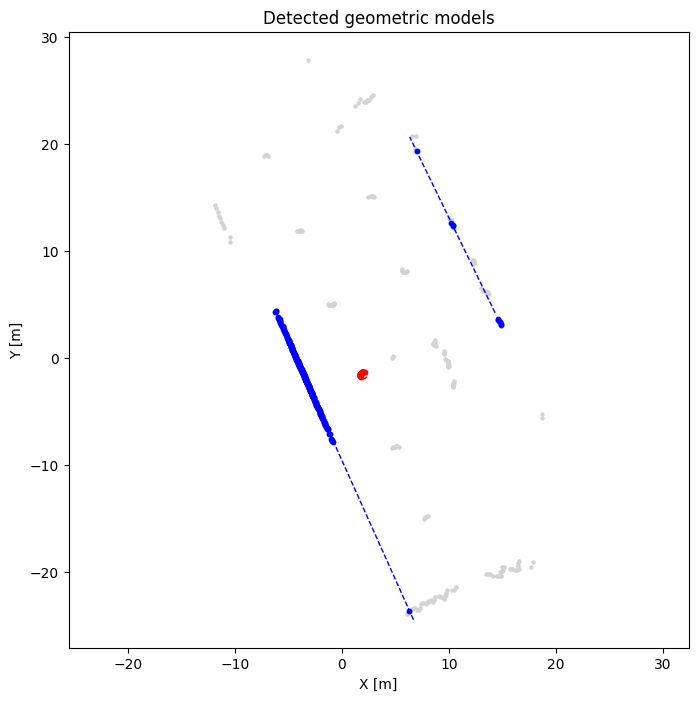


----------------------------------------------------------------------
Run Totals
----------------------------------------------------------------------
Files processed: 2
Total points: 1460
Total lines detected: 12
Total circles detected: 1

Summary saved to: /content/results_summary.txt


In [3]:
# ==========================================================
# 12. Main entry point (Testing to see how the model behaves with other files)
# ==========================================================
if __name__ == "__main__":
    files_to_process = ["19", "29"]
    print("Processing:", files_to_process)
    process_files(files_to_process, visualize=True)